In [3]:
#!pip3 install -e .
import numpy as np
import matplotlib.pyplot as plt
from astropy import convolution
from astropy.io import fits
import astropy
from scipy import signal
from fit_ring import fit_ring

In [4]:
hdulist = fits.open("../obs/hd163296_band6.fits")
wavelength = 0.125
NCUT = 1000
#hdulist = fits.open("../data/hd163296_band4.fits")
#wavelengthcm = 0.2054#299792458e2 　1.459500000000E+11 Hz
# NCUT = 0

# choose data range to fit
r_range = [60.0, 75.0]
limit_theta = True

### Fitting Parameters ###
# ring center of observed image
xcen, ycen = 0.0, 0.0

ring_r0 = 67.0
ring_tau = 1.0
ring_w = 4.0
ring_h = 4.0
temperature_t0 = 20.0
temperature_r0 = 50.0
temperature_pow = -0.5

In [5]:
# distance
dis = 101.0 # pc
# disk geomertry
incl = 46.7/180*np.pi # inclination in degree
posang = 133.1/180*np.pi # position angle in degree
posang_proj = posang + np.pi/2

# read fits data
pic = hdulist[0]
header = pic.header
image = pic.data[0,0]
image = image[NCUT:-NCUT,NCUT:-NCUT]

# check pixcel of figure
NAXIS1 = header['NAXIS1'] - NCUT*2
NAXIS2 = header['NAXIS2'] - NCUT*2
# check range (sec) per pixcel
CDELT1 = header['CDELT1']*3600
CDELT2 = header['CDELT2']*3600
CDELT1 = abs(CDELT1)
CDELT2 = abs(CDELT2)
BMAJ = header['BMAJ']*3600
BMIN = header['BMIN']*3600
BPA = header['BPA']

# Band 6 frequency: 233.0 GHz
freqGHz = 30/wavelength
image = 1.222e6 * image/BMAJ/BMIN/freqGHz**2

CDELT1 = CDELT1 * dis
CDELT2 = CDELT2 * dis
BMAJ = BMAJ * dis
BMIN = BMIN * dis

In [6]:
# smooth B6 image
# bmaj_obs_ker, bmin_obs_ker, bpa_obs_ker = # in au
#beam_kernel = convolution.Gaussian2DKernel(BMIN/2.355/CDELT2, BMAJ/2.355/CDELT1, theta=BPA/180*np.pi).array
# #image = convolution.convolve_fft(image, beam_kernel)
#image = signal.fftconvolve(image, beam_kernel, mode="same") # fastest

In [7]:
import scipy.interpolate as interpolate
# convert to radian
def deproject_image(image, ratio, pa_rad, nx0, ny0):
    nx, ny = image.shape
    # create coordinate system
    x = np.arange(nx)
    y = np.arange(ny)
    xx, yy = np.meshgrid(x, y, indexing="xy")
    # deproject
    dxx1 =  (xx-nx0)*np.cos(pa_rad) + (yy-ny0)*np.sin(pa_rad)
    dyy1 = -(xx-nx0)*np.sin(pa_rad) + (yy-ny0)*np.cos(pa_rad)
    dyy1 = dyy1 / ratio
    xx2 =  dxx1*np.cos(pa_rad) - dyy1*np.sin(pa_rad) + nx0
    yy2 = +dxx1*np.sin(pa_rad) + dyy1*np.cos(pa_rad) + ny0

    # interpolate image
    f = interpolate.RectBivariateSpline(np.arange(nx), np.arange(ny), image.T)
    image_deprojected = f.ev(xx2, yy2)
    return image_deprojected

def deproject_grid(xx, yy, ratio, pa_rad, x0=0, y0=0):
    # deproject
    dxx1 =  (xx-x0)*np.cos(pa_rad) + (yy-y0)*np.sin(pa_rad)
    dyy1 = -(xx-x0)*np.sin(pa_rad) + (yy-y0)*np.cos(pa_rad)
    dyy1 = dyy1 / ratio
    xx2 =  dxx1*np.cos(pa_rad) - dyy1*np.sin(pa_rad) + x0
    yy2 = +dxx1*np.sin(pa_rad) + dyy1*np.cos(pa_rad) + y0
    return xx2, yy2

# deproject all images
image_deproj = deproject_image(image, 1/np.cos(incl), posang_proj, (NAXIS1-1)/2, (NAXIS2-1)/2)

In [8]:
# make grid
x_obs = np.linspace(-(NAXIS1-1)*CDELT1/2, (NAXIS1-1)*CDELT1/2, NAXIS1)
y_obs = np.linspace(-(NAXIS2-1)*CDELT2/2, (NAXIS2-1)*CDELT2/2, NAXIS2)
xx_obs, yy_obs = np.meshgrid(x_obs, y_obs, indexing='xy')

BMAJ_smooth = BMAJ
BMIN_smooth = BMIN
BPA_smooth = BPA
B_ave_smooth = np.sqrt(BMAJ_smooth*BMIN_smooth)

n_grid_half = int(r_range[1]/B_ave_smooth)
x_data_point = np.arange(-n_grid_half, n_grid_half+1) * B_ave_smooth
y_data_point = np.arange(-n_grid_half, n_grid_half+1) * B_ave_smooth
xx_data_point, yy_data_point = np.meshgrid(x_data_point, y_data_point, indexing='xy')
xx_data_point = xx_data_point.flatten()
yy_data_point = yy_data_point.flatten()

# deproject grid
xx_data_point_deproj, yy_data_point_deproj = deproject_grid(xx_data_point, yy_data_point, np.cos(incl), posang_proj)

rr_data_point = np.sqrt(xx_data_point_deproj**2 + yy_data_point_deproj**2)
theta_data_point = np.arctan2(yy_data_point_deproj, xx_data_point_deproj)

# choose data points to fit
xx_data_point = xx_data_point[(rr_data_point>r_range[0]) & (rr_data_point<r_range[1])]
yy_data_point = yy_data_point[(rr_data_point>r_range[0]) & (rr_data_point<r_range[1])]
xx_data_point_deproj = xx_data_point_deproj[(rr_data_point>r_range[0]) & (rr_data_point<r_range[1])]
yy_data_point_deproj = yy_data_point_deproj[(rr_data_point>r_range[0]) & (rr_data_point<r_range[1])]
if (limit_theta):
    xx_data_point, yy_data_point = xx_data_point[(xx_data_point_deproj>0) | (yy_data_point_deproj>0)], yy_data_point[(xx_data_point_deproj>0) | (yy_data_point_deproj>0)]
    xx_data_point_deproj, yy_data_point_deproj = xx_data_point_deproj[(xx_data_point_deproj>0) | (yy_data_point_deproj>0)], yy_data_point_deproj[(xx_data_point_deproj>0) | (yy_data_point_deproj>0)]

In [9]:
x_model = np.linspace(-100, 100, 201)
y_model = np.linspace(-100, 100, 201)
xx_model, yy_model  = np.meshgrid(x_model, y_model, indexing="xy")

nx, ny = xx_model.shape

xx_model_incl = deproject_image(xx_model, np.cos(incl), posang_proj, (nx-1)/2, (ny-1)/2)
yy_model_incl = deproject_image(yy_model, np.cos(incl), posang_proj, (nx-1)/2, (ny-1)/2)

bmaj_model = BMAJ_smooth
bmin_model = BMIN_smooth
bpa_model = BPA_smooth
dx = x_model[1] - x_model[0]
dy = y_model[1] - y_model[0]
bmaj_model_n = bmaj_model / dx
bmin_model_n = bmin_model / dx

beam_kernel = convolution.Gaussian2DKernel(bmin_model_n/2.35, bmaj_model/2.35, bpa_model).array

In [10]:
beam_kernel.shape

(17, 17)

In [47]:
### Fitting Parameters ###
# ring center of observed image
# fitted parameters
xcen, ycen = 0, 0
ring_r0 = 67.0
ring_tau = 1.0
ring_w = 4.0
ring_h = 4.0

# fixed parameters
temperature_t0 = 21.8
temperature_r0 = 100.0
temperature_pow = -0.5


# the most important part for mcmc fitting
xx_data_point_cen = xx_data_point + xcen
yy_data_point_cen = yy_data_point + ycen
obs_data_points = fit_ring.interpolate_data(x_obs, y_obs, image.T, xx_data_point_cen, yy_data_point_cen)
#obs_data_points_deproj = fit_ring.interpolate_data(x_obs, y_obs, image_deproj.T, xx_data_point_deproj, yy_data_point_deproj)

intensity = fit_ring.raytrace_ring(ring_r0, ring_tau, ring_w, ring_h, incl, posang, temperature_t0, temperature_r0, temperature_pow, wavelength, xx_model_incl, yy_model_incl)
intensity_conv = fit_ring.convolution(intensity, beam_kernel)
model_data_points = fit_ring.interpolate_data(x_model, y_model, intensity_conv.T, xx_data_point, yy_data_point)

chi2 = np.sum((obs_data_points - model_data_points)**2)


In [103]:
sigma = .26 # K



def log_likelihood(params, sigma):
    xcen, ycen, ring_r0, ring_tau, ring_w, ring_h = params
    # the most important part for mcmc fitting
    xx_data_point_cen = xx_data_point + xcen
    yy_data_point_cen = yy_data_point + ycen
    obs_data_points = fit_ring.interpolate_data(x_obs, y_obs, image.T, xx_data_point_cen, yy_data_point_cen)
    #obs_data_points_deproj = fit_ring.interpolate_data(x_obs, y_obs, image_deproj.T, xx_data_point_deproj, yy_data_point_deproj)
    intensity = fit_ring.raytrace_ring(ring_r0, ring_tau, ring_w, ring_h, incl, posang, temperature_t0, temperature_r0, temperature_pow, wavelength, xx_model_incl, yy_model_incl)
    #intensity_conv = fit_ring.convolution(intensity, beam_kernel)
    intensity_conv = signal.fftconvolve(intensity, beam_kernel, mode="same")
    model_data_points = fit_ring.interpolate_data(x_model, y_model, intensity_conv.T, xx_data_point, yy_data_point)
    chi2 = np.sum((obs_data_points - model_data_points)**2)/sigma**2
    return -0.5 * chi2

def log_prior(params):
    xcen, ycen, ring_r0, ring_tau, ring_w, ring_h = params
    if 0.0<xcen<2.0 and 0.0< ycen<2.0 and 66.5<ring_r0<68.5 and 0.0<ring_tau<1.0 and 3.0<ring_w<6.0 and 0.0<ring_h<5.0:
        return 0.0
    return -np.inf

def log_probability(params, sigma):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, sigma)

import emcee

#pos = np.array([0.0, 0.0, 67.0, 0.5, 4.0, 2.0])+  1.0* np.random.randn(16, 6)
pos = np.array([0.86, 1.1, 67.8, 0.714, 4.76, 4.10])+  0.1* np.random.randn(32, 6)
nwalkers, ndim = pos.shape

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=([sigma]))
#sampler.run_mcmc(pos, 1000, progress=True)

from multiprocessing import Pool, get_context

num_cores=8
#with Pool(num_cores) as pool: # for Intel CPU
with get_context("fork").Pool(num_cores) as pool: # for M1 Mac
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=([sigma]), pool=pool)
    sampler.run_mcmc(pos, 2000, progress=True)

  3%|▎         | 27/1000 [00:18<11:04,  1.46it/s]


KeyboardInterrupt: 

(15200, 6)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

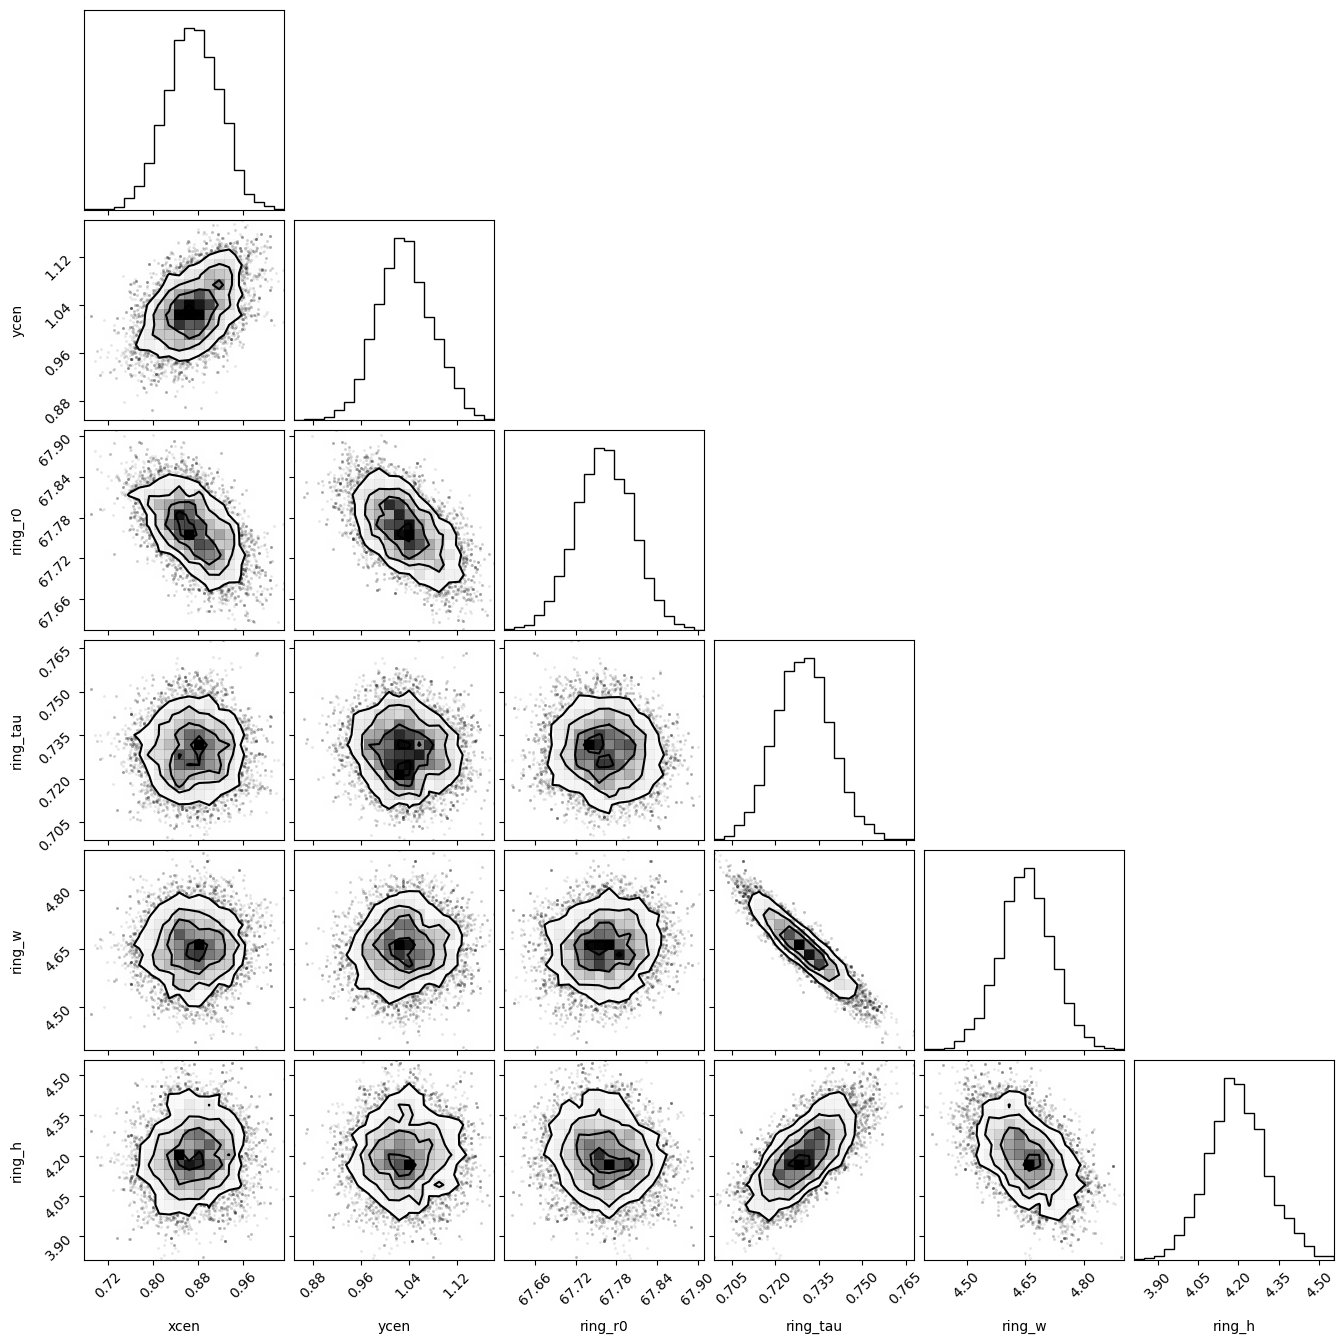

In [100]:
flat_samples = sampler.get_chain(discard=50, thin=1, flat=True)
print(flat_samples.shape)

import corner

labels = ["xcen", "ycen", "ring_r0", "ring_tau", "ring_w", "ring_h"]
fig = corner.corner(
    flat_samples, labels=labels
);

from IPython.display import display, Math

labels = ["xcen", "ycen", "ring_r0", "ring_tau", "ring_w", "ring_h"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

(-66.80978983956, 71.13404808160271, -66.59357692745786, 66.59357692745786)

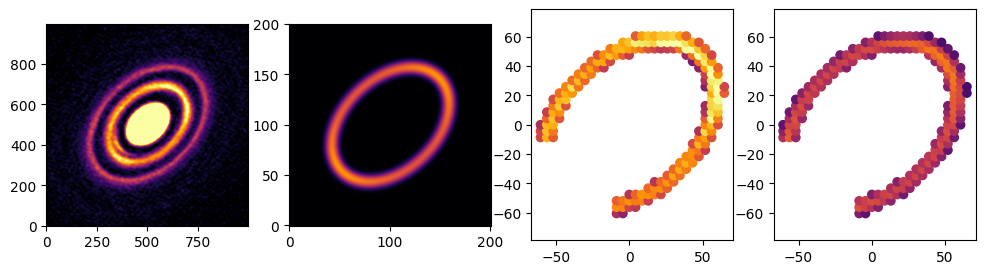

In [18]:
fig = plt.figure(figsize=(12, 3))
ax1 = fig.add_subplot(141)
ax1.imshow(image, origin="lower", cmap="inferno", vmin = 0, vmax = 10)
ax2 = fig.add_subplot(142)
ax2.imshow(intensity, origin="lower", cmap="inferno", vmin = 0, vmax = 10)
ax3 = fig.add_subplot(143)
ax3.scatter(xx_data_point, yy_data_point, c=obs_data_points, cmap="inferno", vmin = 0, vmax = 10)
ax3.axis('equal')
ax4 = fig.add_subplot(144)
ax4.scatter(xx_data_point, yy_data_point, c=model_data_points, cmap="inferno", vmin = 0, vmax = 10)
ax4.axis('equal')

(-66.80978983956, 71.13404808160271, -66.59357692745786, 66.59357692745786)

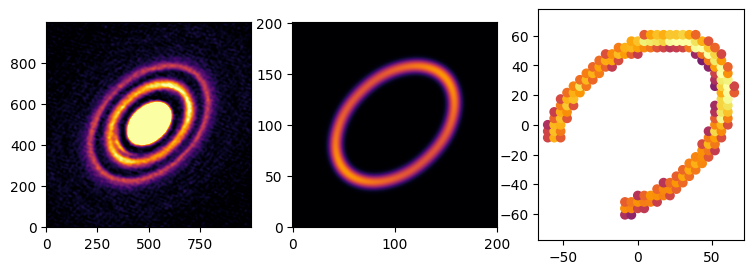

In [ ]:
fig = plt.figure(figsize=(9, 3))
ax1 = fig.add_subplot(131)
ax1.imshow(image, origin="lower", cmap="inferno", vmin = 0, vmax = 10)
ax2 = fig.add_subplot(132)
ax2.imshow(intensity, origin="lower", cmap="inferno", vmin = 0, vmax = 10)
ax3 = fig.add_subplot(133)
ax3.scatter(xx_data_point, yy_data_point, c=obs_data_points, cmap="inferno", vmin = 0, vmax = 10)
ax3.axis('equal')

In [35]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

8 CPUs
